## 卷积神经网络（Convolutional Neural Network, CNN）

## 项目：实现一个狗品种识别算法App

在这个notebook文件中，有些模板代码已经提供给你，但你还需要实现更多的功能来完成这个项目。除非有明确要求，你无须修改任何已给出的代码。以**'(练习)'**开始的标题表示接下来的代码部分中有你需要实现的功能。这些部分都配有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示。

除了实现代码外，你还**需要**回答一些与项目及代码相关的问题。每个需要回答的问题都会以 **'问题 X'** 标记。请仔细阅读每个问题，并且在问题后的 **'回答'** 部分写出完整的答案。我们将根据 你对问题的回答 和 撰写代码实现的功能 来对你提交的项目进行评分。

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

项目中显示为_选做_的部分可以帮助你的项目脱颖而出，而不是仅仅达到通过的最低要求。如果你决定追求更高的挑战，请在此 notebook 中完成_选做_部分的代码。

---

### 让我们开始吧
在这个notebook中，你将迈出第一步，来开发可以作为移动端或 Web应用程序一部分的算法。在这个项目的最后，你的程序将能够把用户提供的任何一个图像作为输入。如果可以从图像中检测到一只狗，它会输出对狗品种的预测。如果图像中是一个人脸，它会预测一个与其最相似的狗的种类。下面这张图展示了完成项目后可能的输出结果。（……实际上我们希望每个学生的输出结果不相同！）

![Sample Dog Output](images/sample_dog_output.png)

在现实世界中，你需要拼凑一系列的模型来完成不同的任务；举个例子，用来预测狗种类的算法会与预测人类的算法不同。在做项目的过程中，你可能会遇到不少失败的预测，因为并不存在完美的算法和模型。你最终提交的不完美的解决方案也一定会给你带来一个有趣的学习经验！

### 项目内容

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 0](#step0): 导入数据集
* [Step 1](#step1): 检测人脸
* [Step 2](#step2): 检测狗狗
* [Step 3](#step3): 从头创建一个CNN来分类狗品种
* [Step 4](#step4): 使用一个CNN来区分狗的品种(使用迁移学习)
* [Step 5](#step5): 建立一个CNN来分类狗的品种（使用迁移学习）
* [Step 6](#step6): 完成你的算法
* [Step 7](#step7): 测试你的算法

在该项目中包含了如下的问题：

* [问题 1](#question1)
* [问题 2](#question2)
* [问题 3](#question3)
* [问题 4](#question4)
* [问题 5](#question5)
* [问题 6](#question6)
* [问题 7](#question7)
* [问题 8](#question8)
* [问题 9](#question9)
* [问题 10](#question10)
* [问题 11](#question11)


---
<a id='step0'></a>
## 步骤 0: 导入数据集

### 导入狗数据集
在下方的代码单元（cell）中，我们导入了一个狗图像的数据集。我们使用 scikit-learn 库中的 `load_files` 函数来获取一些变量：
- `train_files`, `valid_files`, `test_files` - 包含图像的文件路径的numpy数组
- `train_targets`, `valid_targets`, `test_targets` - 包含独热编码分类标签的numpy数组
- `dog_names` - 由字符串构成的与标签相对应的狗的种类

In [8]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# 定义函数来加载train，test和validation数据集
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# 加载train，test和validation数据集
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# 加载狗品种列表
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# 打印数据统计描述
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 导入人脸数据集

在下方的代码单元中，我们导入人脸图像数据集，文件所在路径存储在名为 `human_files` 的 numpy 数组。

In [9]:
import random
random.seed(8675309)

# 加载打乱后的人脸数据集的文件名
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# 打印数据集的数据量
print('There are %d total human images.' % len(human_files))
print(human_files.shape)

There are 13233 total human images.
(13233,)


---
<a id='step1'></a>
## 步骤1：检测人脸
 
我们将使用 OpenCV 中的 [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) 来检测图像中的人脸。OpenCV 提供了很多预训练的人脸检测模型，它们以XML文件保存在 [github](https://github.com/opencv/opencv/tree/master/data/haarcascades)。我们已经下载了其中一个检测模型，并且把它存储在 `haarcascades` 的目录中。

在如下代码单元中，我们将演示如何使用这个检测模型在样本图像中找到人脸。

Number of faces detected: 1


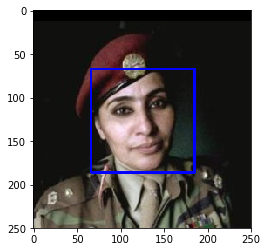

In [10]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# 提取预训练的人脸检测模型
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# 加载彩色（通道顺序为BGR）图像
img = cv2.imread(human_files[3])

# 将BGR图像进行灰度处理
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 在图像中找出脸
faces = face_cascade.detectMultiScale(gray)

# 打印图像中检测到的脸的个数
print('Number of faces detected:', len(faces))

# 获取每一个所检测到的脸的识别框
for (x,y,w,h) in faces:
    # 在人脸图像中绘制出识别框
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# 将BGR图像转变为RGB图像以打印
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 展示含有识别框的图像
plt.imshow(cv_rgb)
plt.show()

在使用任何一个检测模型之前，将图像转换为灰度图是常用过程。`detectMultiScale` 函数使用储存在 `face_cascade` 中的的数据，对输入的灰度图像进行分类。

在上方的代码中，`faces` 以 numpy 数组的形式，保存了识别到的面部信息。它其中每一行表示一个被检测到的脸，该数据包括如下四个信息：前两个元素  `x`、`y` 代表识别框左上角的 x 和 y 坐标（参照上图，注意 y 坐标的方向和我们默认的方向不同）；后两个元素代表识别框在 x 和 y 轴两个方向延伸的长度 `w` 和 `d`。 

### 写一个人脸识别器

我们可以将这个程序封装为一个函数。该函数的输入为人脸图像的**路径**，当图像中包含人脸时，该函数返回 `True`，反之返回 `False`。该函数定义如下所示。

In [11]:
# 如果img_path路径表示的图像检测到了脸，返回"True" 
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### **【练习】** 评估人脸检测模型


---

<a id='question1'></a>
### __问题 1:__ 

在下方的代码块中，使用 `face_detector` 函数，计算：

- `human_files` 的前100张图像中，能够检测到**人脸**的图像占比多少？
- `dog_files` 的前100张图像中，能够检测到**人脸**的图像占比多少？

理想情况下，人图像中检测到人脸的概率应当为100%，而狗图像中检测到人脸的概率应该为0%。你会发现我们的算法并非完美，但结果仍然是可以接受的。我们从每个数据集中提取前100个图像的文件路径，并将它们存储在`human_files_short`和`dog_files_short`中。

In [14]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
## 请不要修改上方代码


## TODO: 基于human_files_short和dog_files_short
## 中的图像测试face_detector的表现
def detect(detector,files):
    return np.mean([detector(f) for f in files])

print('human: {:.2%}'.format(detect(face_detector,human_files_short)))
print('dog: {:.2%}'.format(detect(face_detector,dog_files_short)))

human: 100.00%
dog: 11.00%


---

<a id='question2'></a>

### __问题 2:__ 

就算法而言，该算法成功与否的关键在于，用户能否提供含有清晰面部特征的人脸图像。
那么你认为，这样的要求在实际使用中对用户合理吗？如果你觉得不合理，你能否想到一个方法，即使图像中并没有清晰的面部特征，也能够检测到人脸？

__回答:__

不合理，使用深度学习能从不清晰的面部特征中，检测到人脸。

---

<a id='Selection1'></a>
### 选做：

我们建议在你的算法中使用opencv的人脸检测模型去检测人类图像，不过你可以自由地探索其他的方法，尤其是尝试使用深度学习来解决它:)。请用下方的代码单元来设计和测试你的面部监测算法。如果你决定完成这个_选做_任务，你需要报告算法在每一个数据集上的表现。

In [15]:
## (选做) TODO: 报告另一个面部检测算法在LFW数据集上的表现
### 你可以随意使用所需的代码单元数

In [16]:
from PIL import Image

photo_size = 64
samples = 1000 

# 导入图片作为训练集
def load_data(path_array,photo_size = 64):
    arr = []
    for path in path_array:
        img = Image.open(path)
        resize_img = img.resize((photo_size,photo_size))
        img_arr =  np.array(resize_img).reshape(1,photo_size,photo_size,3)
        if not len(arr):
            arr = img_arr
        else:
            arr = np.append(arr,img_arr,axis=0)
    return arr

human_train = load_data( human_files[100:100 + samples],photo_size)
dog_train = load_data( train_files[100:100 + samples],photo_size)

human_train.shape,dog_train.shape

((1000, 64, 64, 3), (1000, 64, 64, 3))

In [17]:
#整理一
from sklearn.utils import shuffle

train_X = np.append(human_train,dog_train,axis=0)
train_X = train_X /255.0
train_y = np.append([[1,0] for i in range(samples)],
                    [[0,1] for i in range(samples)],axis=0)

shuffled_train_X,shuffled_train_y = shuffle(train_X,train_y, random_state=0)
train_X.shape,train_y.shape

((2000, 64, 64, 3), (2000, 2))

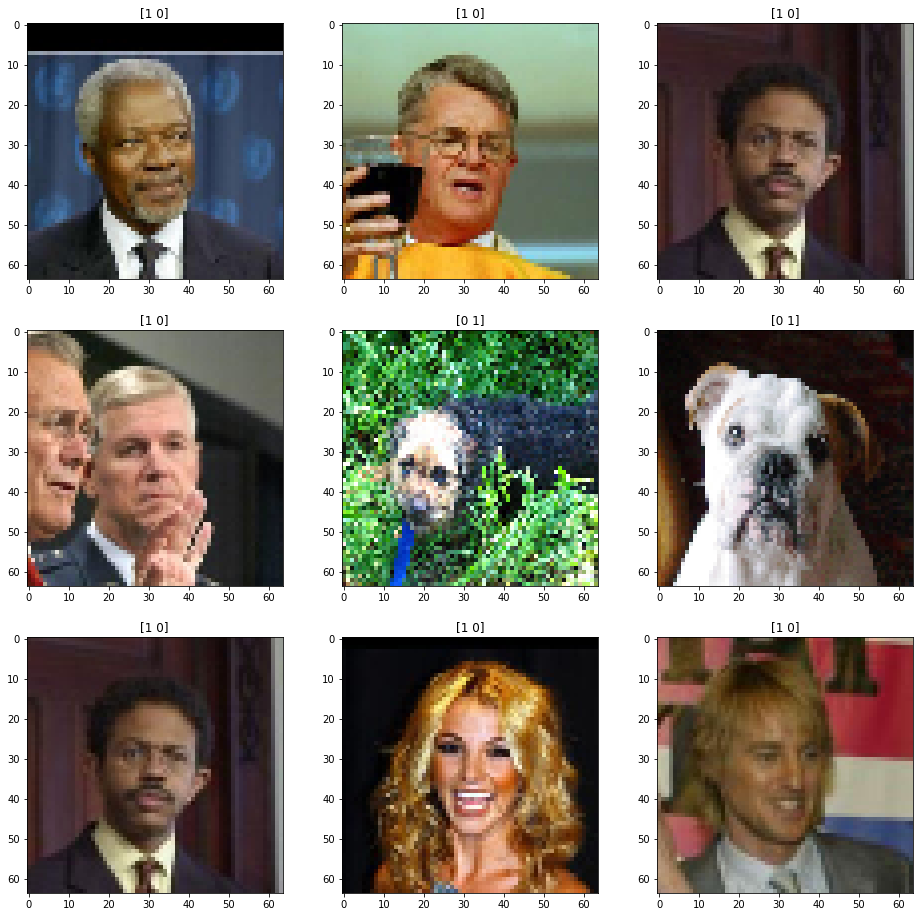

In [18]:
# 可视化数据
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))

for id,ax in zip(rand_idxs,m_axs.flatten()):
    ax.imshow(shuffled_train_X[id])
    ax.set_title(shuffled_train_y[id])

In [42]:
# 设计模型
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(photo_size, photo_size, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 128)       73856     
__________

In [43]:
# 训练模型
model.fit(shuffled_train_X,shuffled_train_y,epochs=20,batch_size=128)

Epoch 1/20
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6071
Epoch 2/20
2000/2000 [==============================] - 2s 805us/step - loss: 0.5193
Epoch 3/20
2000/2000 [==============================] - 2s 801us/step - loss: 0.2349
Epoch 4/20
2000/2000 [==============================] - 2s 799us/step - loss: 0.1641
Epoch 5/20
2000/2000 [==============================] - 2s 802us/step - loss: 0.1250
Epoch 6/20
2000/2000 [==============================] - 2s 800us/step - loss: 0.0700
Epoch 7/20
2000/2000 [==============================] - 2s 803us/step - loss: 0.0423
Epoch 8/20
2000/2000 [==============================] - 2s 805us/step - loss: 0.0258
Epoch 9/20
2000/2000 [==============================] - 2s 804us/step - loss: 0.0189
Epoch 10/20
2000/2000 [==============================] - 2s 795us/step - loss: 0.0102
Epoch 11/20
2000/2000 [==============================] - 2s 793us/step - loss: 0.0179
Epoch 12/20
2000/2000 [==============================] - 2s 797us

In [44]:
# 预测以及探索算法在每一个数据集上的表现

human_test = load_data( human_files_short,photo_size)/255
dog_test = load_data( dog_files_short,photo_size)/255

human_pre = model.predict(human_test)
dog_pre = model.predict(dog_test)

print('human: {:.2%}'.format(np.mean(1-human_pre.argmax(axis=1))))
print('dog: {:.2%}'.format(np.mean(1-dog_pre.argmax(axis=1))))

human: 100.00%
dog: 0.00%


---
<a id='step2'></a>

## 步骤 2: 检测狗狗

在这个部分中，我们使用预训练的 [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) 模型去检测图像中的狗。下方的第一行代码就是下载了 ResNet-50 模型的网络结构参数，以及基于 [ImageNet](http://www.image-net.org/) 数据集的预训练权重。

ImageNet 这目前一个非常流行的数据集，常被用来测试图像分类等计算机视觉任务相关的算法。它包含超过一千万个 URL，每一个都链接到 [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 中所对应的一个物体的图像。任给输入一个图像，该 ResNet-50 模型会返回一个对图像中物体的预测结果。

In [23]:
from keras.applications.resnet50 import ResNet50

# 定义ResNet50模型
ResNet50_model = ResNet50(weights='imagenet')

### 数据预处理

- 在使用 TensorFlow 作为后端的时候，在 Keras 中，CNN 的输入是一个4维数组（也被称作4维张量），它的各维度尺寸为 `(nb_samples, rows, columns, channels)`。其中 `nb_samples` 表示图像（或者样本）的总数，`rows`, `columns`, 和 `channels` 分别表示图像的行数、列数和通道数。


- 下方的 `path_to_tensor` 函数实现如下将彩色图像的字符串型的文件路径作为输入，返回一个4维张量，作为 Keras CNN 输入。因为我们的输入图像是彩色图像，因此它们具有三个通道（ `channels` 为 `3`）。
    1. 该函数首先读取一张图像，然后将其缩放为 224×224 的图像。
    2. 随后，该图像被调整为具有4个维度的张量。
    3. 对于任一输入图像，最后返回的张量的维度是：`(1, 224, 224, 3)`。


- `paths_to_tensor` 函数将图像路径的字符串组成的 numpy 数组作为输入，并返回一个4维张量，各维度尺寸为 `(nb_samples, 224, 224, 3)`。 在这里，`nb_samples`是提供的图像路径的数据中的样本数量或图像数量。你也可以将 `nb_samples` 理解为数据集中3维张量的个数（每个3维张量表示一个不同的图像。

In [24]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(224, 224))
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### 基于 ResNet-50 架构进行预测

对于通过上述步骤得到的四维张量，在把它们输入到 ResNet-50 网络、或 Keras 中其他类似的预训练模型之前，还需要进行一些额外的处理：
1. 首先，这些图像的通道顺序为 RGB，我们需要重排他们的通道顺序为 BGR。
2. 其次，预训练模型的输入都进行了额外的归一化过程。因此我们在这里也要对这些张量进行归一化，即对所有图像所有像素都减去像素均值 `[103.939, 116.779, 123.68]`（以 RGB 模式表示，根据所有的 ImageNet 图像算出）。

导入的 `preprocess_input` 函数实现了这些功能。如果你对此很感兴趣，可以在 [这里](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py) 查看 `preprocess_input`的代码。


在实现了图像处理的部分之后，我们就可以使用模型来进行预测。这一步通过 `predict` 方法来实现，它返回一个向量，向量的第 i 个元素表示该图像属于第 i 个 ImageNet 类别的概率。这通过如下的 `ResNet50_predict_labels` 函数实现。

通过对预测出的向量取用 argmax 函数（找到有最大概率值的下标序号），我们可以得到一个整数，即模型预测到的物体的类别。进而根据这个 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)，我们能够知道这具体是哪个品种的狗狗。


In [25]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
def ResNet50_predict_labels(img_path):
    # 返回img_path路径的图像的预测向量
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### 完成狗检测模型


在研究该 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 的时候，你会注意到，狗类别对应的序号为151-268。因此，在检查预训练模型判断图像是否包含狗的时候，我们只需要检查如上的 `ResNet50_predict_labels` 函数是否返回一个介于151和268之间（包含区间端点）的值。

我们通过这些想法来完成下方的 `dog_detector` 函数，如果从图像中检测到狗就返回 `True`，否则返回 `False`。

In [26]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### 【作业】评估狗狗检测模型

---

<a id='question3'></a>
### __问题 3:__ 

在下方的代码块中，使用 `dog_detector` 函数，计算：

- `human_files_short`中图像检测到狗狗的百分比？
- `dog_files_short`中图像检测到狗狗的百分比？

In [27]:
### TODO: 测试dog_detector函数在human_files_short和dog_files_short的表现

print('human: {:.2%}'.format(detect(dog_detector, human_files_short)))
print('dog: {:.2%}'.format(detect(dog_detector, dog_files_short)))

human: 0.00%
dog: 100.00%


---

<a id='step3'></a>

## 步骤 3: 从头开始创建一个CNN来分类狗品种


现在我们已经实现了一个函数，能够在图像中识别人类及狗狗。但我们需要更进一步的方法，来对狗的类别进行识别。在这一步中，你需要实现一个卷积神经网络来对狗的品种进行分类。你需要__从头实现__你的卷积神经网络（在这一阶段，你还不能使用迁移学习），并且你需要达到超过1%的测试集准确率。在本项目的步骤五种，你还有机会使用迁移学习来实现一个准确率大大提高的模型。

在添加卷积层的时候，注意不要加上太多的（可训练的）层。更多的参数意味着更长的训练时间，也就是说你更可能需要一个 GPU 来加速训练过程。万幸的是，Keras 提供了能够轻松预测每次迭代（epoch）花费时间所需的函数。你可以据此推断你算法所需的训练时间。

值得注意的是，对狗的图像进行分类是一项极具挑战性的任务。因为即便是一个正常人，也很难区分布列塔尼犬和威尔士史宾格犬。


布列塔尼犬（Brittany） | 威尔士史宾格犬（Welsh Springer Spaniel）
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

不难发现其他的狗品种会有很小的类间差别（比如金毛寻回犬和美国水猎犬）。


金毛寻回犬（Curly-Coated Retriever） | 美国水猎犬（American Water Spaniel）
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

同样，拉布拉多犬（labradors）有黄色、棕色和黑色这三种。那么你设计的基于视觉的算法将不得不克服这种较高的类间差别，以达到能够将这些不同颜色的同类狗分到同一个品种中。

黄色拉布拉多犬（Yellow Labrador） | 棕色拉布拉多犬（Chocolate Labrador） | 黑色拉布拉多犬（Black Labrador）
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

我们也提到了随机分类将得到一个非常低的结果：不考虑品种略有失衡的影响，随机猜测到正确品种的概率是1/133，相对应的准确率是低于1%的。

请记住，在深度学习领域，实践远远高于理论。大量尝试不同的框架吧，相信你的直觉！当然，玩得开心！


### 数据预处理


通过对每张图像的像素值除以255，我们对图像实现了归一化处理。

In [28]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# Keras中的数据预处理过程
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:10<00:00, 83.49it/s] 


In [29]:
train_tensors.shape

(6680, 224, 224, 3)

### 【练习】模型架构


创建一个卷积神经网络来对狗品种进行分类。在你代码块的最后，执行 `model.summary()` 来输出你模型的总结信息。
    
我们已经帮你导入了一些所需的 Python 库，如有需要你可以自行导入。如果你在过程中遇到了困难，如下是给你的一点小提示——该模型能够在5个 epoch 内取得超过1%的测试准确率，并且能在CPU上很快地训练。

![Sample CNN](images/sample_cnn.png)

---

<a id='question4'></a>  

### __问题 4:__ 

在下方的代码块中尝试使用 Keras 搭建卷积网络的架构，并回答相关的问题。

1. 你可以尝试自己搭建一个卷积网络的模型，那么你需要回答你搭建卷积网络的具体步骤（用了哪些层）以及为什么这样搭建。
2. 你也可以根据上图提示的步骤搭建卷积网络，那么请说明为何如上的架构能够在该问题上取得很好的表现。

__回答:__ 

自己搭建模型：

我使用了卷积层，最大池化层，线性层（dense），dropout，relu，softmax，GlobalAveragePooling2D

- 卷积层：使用卷积层来学习特征
- 最大池化层：减少参数
- relu：激活函数，使模型非线性
- softmax：把输出转化为概率
- droput：避免模型过拟合
- GlobalAveragePooling2D:减少参数，展开
- dense：线性计算把输出指定为狗狗类别的数量

In [59]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense,BatchNormalization,Activation
from keras.models import Sequential

model = Sequential()

### TODO: 定义你的网络架构
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(GlobalAveragePooling2D())

model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 220, 220, 32)      128       
_________________________________________________________________
activation_103 (Activation)  (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 108, 108, 32)      9248      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 106, 106, 32)      9248      
__________

In [60]:
## 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

---

## 【练习】训练模型


---

<a id='question5'></a>  

### __问题 5:__ 

在下方代码单元训练模型。使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型。

可选题：你也可以对训练集进行 [数据增强](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)，来优化模型的表现。



In [67]:
from keras.callbacks import ModelCheckpoint,EarlyStopping  
from keras.preprocessing.image import ImageDataGenerator
from time import time

### TODO: 设置训练模型的epochs的数量
start = time()
epochs = 20

### 不要修改下方代码

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=20),
                    steps_per_epoch=len(train_tensors) / 32, validation_data=(valid_tensors, valid_targets),
                    epochs=epochs, callbacks=[checkpointer], verbose=1)


print(time()-start)

Epoch 1/20


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:536: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:544: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


209/208 [==============================] - 52s 248ms/step - loss: 4.4967 - acc: 0.0388 - val_loss: 4.2759 - val_acc: 0.0575
Epoch 2/20
209/208 [==============================] - 51s 245ms/step - loss: 4.4399 - acc: 0.0373 - val_loss: 4.5960 - val_acc: 0.0395
Epoch 3/20
209/208 [==============================] - 51s 246ms/step - loss: 4.3860 - acc: 0.0447 - val_loss: 4.4193 - val_acc: 0.0395
Epoch 4/20
209/208 [==============================] - 51s 246ms/step - loss: 4.3416 - acc: 0.0459 - val_loss: 4.2564 - val_acc: 0.0443
Epoch 5/20
209/208 [==============================] - 51s 246ms/step - loss: 4.3218 - acc: 0.0435 - val_loss: 4.6167 - val_acc: 0.0419
Epoch 6/20
209/208 [==============================] - 51s 246ms/step - loss: 4.2855 - acc: 0.0495 - val_loss: 4.1318 - val_acc: 0.0635
Epoch 7/20
209/208 [==============================] - 52s 247ms/step - loss: 4.2635 - acc: 0.0522 - val_loss: 4.1160 - val_acc: 0.0611
Epoch 8/20
209/208 [==============================] - 52s 247ms/st

In [56]:
## 加载具有最好验证loss的模型

model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### 测试模型

在狗图像的测试数据集上试用你的模型。确保测试准确率大于1%。

In [68]:
# 获取测试数据集中每一个图像所预测的狗品种的index
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.4498%


---
<a id='step4'></a>
## 步骤 4: 使用一个CNN来区分狗的品种


使用 迁移学习（Transfer Learning）的方法，能帮助我们在不损失准确率的情况下大大减少训练时间。在以下步骤中，你可以尝试使用迁移学习来训练你自己的CNN。


### 得到从图像中提取的特征向量（Bottleneck Features）

In [69]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

train_VGG16.shape,valid_VGG16.shape,test_VGG16.shape

((6680, 7, 7, 512), (835, 7, 7, 512), (836, 7, 7, 512))

### 模型架构

该模型使用预训练的 VGG-16 模型作为固定的图像特征提取器，其中 VGG-16 最后一层卷积层的输出被直接输入到我们的模型。我们只需要添加一个全局平均池化层以及一个全连接层，其中全连接层使用 softmax 激活函数，对每一个狗的种类都包含一个节点。

In [70]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [71]:
## 编译模型

VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [72]:
## 训练模型

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 442us/step - loss: 12.0920 - acc: 0.1214 - val_loss: 10.4895 - val_acc: 0.2144
Epoch 2/20
6680/6680 [==============================] - 2s 259us/step - loss: 9.7879 - acc: 0.2874 - val_loss: 9.7756 - val_acc: 0.3042
Epoch 3/20
6680/6680 [==============================] - 2s 262us/step - loss: 9.1774 - acc: 0.3594 - val_loss: 9.2842 - val_acc: 0.3401
Epoch 4/20
6680/6680 [==============================] - 2s 273us/step - loss: 8.6826 - acc: 0.4025 - val_loss: 8.9136 - val_acc: 0.3641
Epoch 5/20
6680/6680 [==============================] - 2s 276us/step - loss: 8.3802 - acc: 0.4346 - val_loss: 8.8721 - val_acc: 0.3832
Epoch 6/20
6680/6680 [==============================] - 2s 276us/step - loss: 8.2769 - acc: 0.4540 - val_loss: 8.9874 - val_acc: 0.3629
Epoch 7/20
6680/6680 [==============================] - 2s 275us/step - loss: 8.1908 - acc: 0.4629 - val_loss: 8.9218 - val_acc: 0.3701

In [73]:
## 加载具有最好验证loss的模型

VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### 测试模型
现在，我们可以测试此CNN在狗图像测试数据集中识别品种的效果如何。我们在下方打印出测试准确率。

In [74]:
# 获取测试数据集中每一个图像所预测的狗品种的index
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.4545%


### 使用模型预测狗的品种

In [75]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # 获取预测向量
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # 返回此模型预测的狗的品种
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## 步骤 5: 建立一个CNN来分类狗的品种（使用迁移学习）

现在你将使用迁移学习来建立一个CNN，从而可以从图像中识别狗的品种。你的 CNN 在测试集上的准确率必须至少达到60%。

在步骤4中，我们使用了迁移学习来创建一个使用基于 VGG-16 提取的特征向量来搭建一个 CNN。在本部分内容中，你必须使用另一个预训练模型来搭建一个 CNN。为了让这个任务更易实现，我们已经预先对目前 keras 中可用的几种网络进行了预训练：

- [VGG-19](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/DLND+documents/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/DLND+documents/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/DLND+documents/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/DLND+documents/DogXceptionData.npz) bottleneck features

这些文件被命名为为：

    Dog{network}Data.npz

其中 `{network}` 可以是 `VGG19`、`Resnet50`、`InceptionV3` 或 `Xception` 中的一个。选择上方网络架构中的一个，下载相对应的bottleneck特征，并将所下载的文件保存在目录 `bottleneck_features/` 中。


### 【练习】获取模型的特征向量

在下方代码块中，通过运行下方代码提取训练、测试与验证集相对应的bottleneck特征。

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [76]:
### TODO: 从另一个预训练的CNN获取bottleneck特征

bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

train_Resnet50.shape,valid_Resnet50.shape,test_Resnet50.shape

((6680, 1, 1, 2048), (835, 1, 1, 2048), (836, 1, 1, 2048))

### 【练习】模型架构

建立一个CNN来分类狗品种。在你的代码单元块的最后，通过运行如下代码输出网络的结构：
    
        <your model's name>.summary()
   
---

<a id='question6'></a>  

### __问题 6:__ 


在下方的代码块中尝试使用 Keras 搭建最终的网络架构，并回答你实现最终 CNN 架构的步骤与每一步的作用，并描述你在迁移学习过程中，使用该网络架构的原因。


__回答:__ 

- 我选择从Resnet50提取的特征向量来训练，因为Resnet50计算量较小，表现较高。
- 我用Resnet50提取的特征向量中一行的shape作为输入，输出133维的向量，因为狗的种类是133种
- 因为是多分类问题，激活函数使用softmax
- 使用迁移学习的原因是：
    1. 都是图像分类问题，Resnet50已经使用花费计算资源训练，虽然最终的目标类别不一样，但是Resnet50学习到的特征可以复用。
    2. 可以节约大量时间，计算资源
- 之前的尝试不成功，由于模型复杂度不够，而且训练的批次较少。


In [77]:
### TODO: 定义你的框架

Resnet50_model = Sequential()
Resnet50_model.add(Flatten(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [78]:
### TODO: 编译模型
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

---

### 【练习】训练模型

<a id='question7'></a>  

### __问题 7:__ 

在下方代码单元中训练你的模型。使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型。

当然，你也可以对训练集进行 [数据增强](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 以优化模型的表现，不过这不是必须的步骤。


In [79]:
### TODO: 训练模型

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 434us/step - loss: 1.6464 - acc: 0.5903 - val_loss: 0.8379 - val_acc: 0.7593
Epoch 2/20
6680/6680 [==============================] - 2s 256us/step - loss: 0.4369 - acc: 0.8611 - val_loss: 0.7740 - val_acc: 0.7677
Epoch 3/20
6680/6680 [==============================] - 2s 258us/step - loss: 0.2668 - acc: 0.9115 - val_loss: 0.6548 - val_acc: 0.8120
Epoch 4/20
6680/6680 [==============================] - 2s 253us/step - loss: 0.1746 - acc: 0.9436 - val_loss: 0.7065 - val_acc: 0.8060
Epoch 5/20
6680/6680 [==============================] - 2s 256us/step - loss: 0.1226 - acc: 0.9614 - val_loss: 0.6853 - val_acc: 0.8108
Epoch 6/20
6680/6680 [==============================] - 2s 257us/step - loss: 0.0835 - acc: 0.9751 - val_loss: 0.7659 - val_acc: 0.8048
Epoch 7/20
6680/6680 [==============================] - 2s 259us/step - loss: 0.0633 - acc: 0.9796 - val_loss: 0.7016 - val_acc: 0.8299
E

In [80]:
### TODO: 加载具有最佳验证loss的模型权重
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

---

### 【练习】测试模型

<a id='question8'></a>  

### __问题 8:__ 

在狗图像的测试数据集上试用你的模型。确保测试准确率大于60%。

In [81]:
### TODO: 在测试集上计算分类准确率

# 获取测试数据集中每一个图像所预测的狗品种的index
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.6220%


---

### 【练习】使用模型测试狗的品种


实现一个函数，它的输入为图像路径，功能为预测对应图像的类别，输出为你模型预测出的狗类别（`Affenpinscher`, `Afghan_hound` 等）。

与步骤5中的模拟函数类似，你的函数应当包含如下三个步骤：

1. 根据选定的模型载入图像特征（bottleneck features）
2. 将图像特征输输入到你的模型中，并返回预测向量。注意，在该向量上使用 argmax 函数可以返回狗种类的序号。
3. 使用在步骤0中定义的 `dog_names` 数组来返回对应的狗种类名称。

提取图像特征过程中使用到的函数可以在 `extract_bottleneck_features.py` 中找到。同时，他们应已在之前的代码块中被导入。根据你选定的 CNN 网络，你可以使用 `extract_{network}` 函数来获得对应的图像特征，其中 `{network}` 代表 `VGG19`, `Resnet50`, `InceptionV3`, 或 `Xception` 中的一个。
 
---

<a id='question9'></a>  

### __问题 9:__

In [82]:
### TODO: 写一个函数，该函数将图像的路径作为输入
### 然后返回此模型所预测的狗的品种
def Resnet50_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # 获取预测向量
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # 返回此模型预测的狗的品种
    return dog_names[np.argmax(predicted_vector)]

predict_breed = Resnet50_predict_breed(train_files[1])
print("predict:", predict_breed)
print("label:",dog_names[np.argmax( train_targets[0])])

94658560/94653016 [==============================] - 2s 0us/step
predict: in/057.Dalmatian
label: in/095.Kuvasz


---

<a id='step6'></a>
## 步骤 6: 完成你的算法



实现一个算法，它的输入为图像的路径，它能够区分图像是否包含一个人、狗或两者都不包含，然后：

- 如果从图像中检测到一只__狗__，返回被预测的品种。
- 如果从图像中检测到__人__，返回最相像的狗品种。
- 如果两者都不能在图像中检测到，输出错误提示。

我们非常欢迎你来自己编写检测图像中人类与狗的函数，你可以随意地使用上方完成的 `face_detector` 和 `dog_detector` 函数。你__需要__在步骤5使用你的CNN来预测狗品种。

下面提供了算法的示例输出，但你可以自由地设计自己的模型！

![Sample Human Output](images/sample_human_output.png)




<a id='question10'></a>  

### __问题 10:__

在下方代码块中完成你的代码。

---


hello, Irish_water_spaniel !


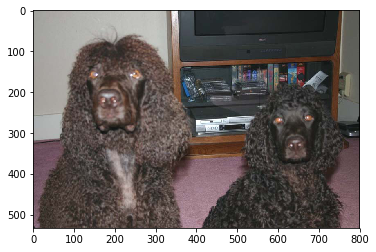

In [83]:
import matplotlib.image as mpimg

### TODO: 设计你的算法
### 自由地使用所需的代码单元数吧
def human_dog_detector(img_path):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    if face_detector(img_path):
        kind = Resnet50_predict_breed(img_path).split('.')[1]
        print('hello,human!')
        print('You look like a ...')
        print(kind)

    elif dog_detector(img_path):

        kind = Resnet50_predict_breed(img_path).split('.')[1]
        print('hello,',kind,'!')

    else: 
        print("Sorry,I can't detective human or dog in this picture!")

img_path = dog_files_short[2]
human_dog_detector(img_path)

---
<a id='step7'></a>
## 步骤 7: 测试你的算法

在这个部分中，你将尝试一下你的新算法！算法认为__你__看起来像什么类型的狗？如果你有一只狗，它可以准确地预测你的狗的品种吗？如果你有一只猫，它会将你的猫误判为一只狗吗？


<a id='question11'></a>  

### __问题 11:__

在下方编写代码，用至少6张现实中的图片来测试你的算法。你可以使用任意照片，不过请至少使用两张人类图片（要征得当事人同意哦）和两张狗的图片。
同时请回答如下问题：

1. 输出结果比你预想的要好吗 :) ？或者更糟 :( ？
2. 提出至少三点改进你的模型的想法。

__回答:__ 

1. 输出的结果比我预计的好，因为测试的分类都是正确的。
2. 三点想法：
    * 用于识别图片里是否有人/狗的模型，准确率还不够，可以替换成cnn的模型。 
    * 识别图片中狗的种类模型准确率在80%左右，考虑用图片增强来提高正确率。
    * 识别速度很慢，考虑更换轻量级的模型，如MobileNet

In [84]:
## TODO: 在你的电脑上，在步骤6中，至少在6张图片上运行你的算法。
## 自由地使用所需的代码单元数吧
local_files = np.array(glob("my_local_picture/*"))
local_files

array(['my_local_picture/dog1.jpg', 'my_local_picture/none5.jpg',
       'my_local_picture/human2.jpg', 'my_local_picture/human1.jpg',
       'my_local_picture/none1.jpg', 'my_local_picture/human3.jpg',
       'my_local_picture/none2.jpg', 'my_local_picture/dog2.jpg',
       'my_local_picture/none4.jpg', 'my_local_picture/none3.jpg'], 
      dtype='<U27')

hello, Golden_retriever !


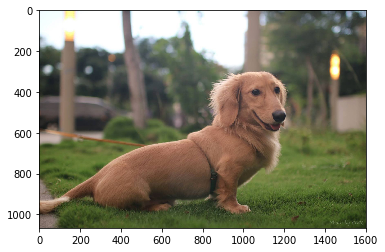

In [85]:
human_dog_detector(local_files[0])

Sorry,I can't detective human or dog in this picture!


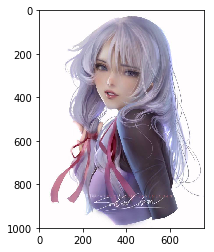

In [86]:
human_dog_detector(local_files[1])

hello,human!
You look like a ...
Silky_terrier


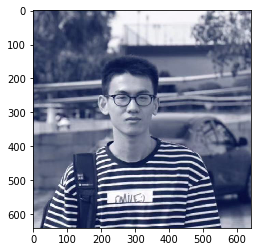

In [87]:
human_dog_detector(local_files[2])

hello,human!
You look like a ...
Norwegian_lundehund


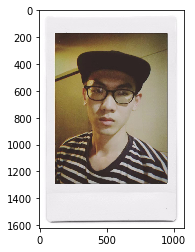

In [88]:
human_dog_detector(local_files[3])

Sorry,I can't detective human or dog in this picture!


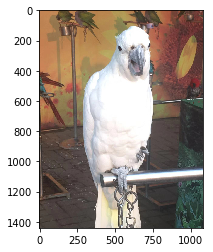

In [89]:
human_dog_detector(local_files[4])

hello,human!
You look like a ...
Basenji


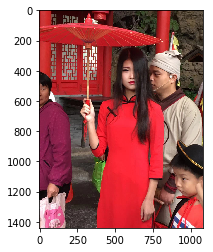

In [90]:
human_dog_detector(local_files[5])

Sorry,I can't detective human or dog in this picture!


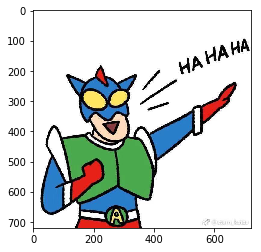

In [91]:
human_dog_detector(local_files[6])

hello, Alaskan_malamute !


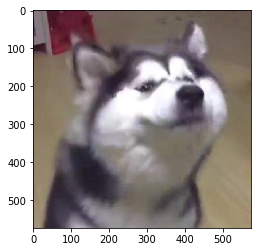

In [92]:
human_dog_detector(local_files[7])

Sorry,I can't detective human or dog in this picture!


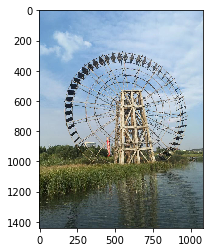

In [93]:
human_dog_detector(local_files[8])

Sorry,I can't detective human or dog in this picture!


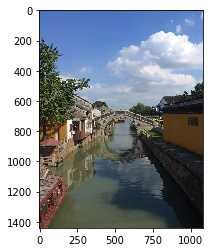

In [94]:
human_dog_detector(local_files[9])

**注意: 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出File -> Download as -> HTML (.html)把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。**